# Introduction to DBSCAN


The algorithm was proposed in the following reference:

[Ester M, Kriegel H, Sander J, Xu X, Idrissov A, Nascimento M et al (1996) A density-based algorithm for discovering clusters in large spatial databases with noise. In: KDD. vol. 2. ACM Press. p. 49–60](https://cdn.aaai.org/KDD/1996/KDD96-037.pdf)

The algorithm requires two hyperparameters, the area radius EPS and the minimum number of points in the neighbourhood (MinPts).

Then, for a given dataset $D$ that consists of a number of points we want to find all clusters $C$.
We start with an empty list for $C$, to which the clusters will be added during the execution.

The general idea is the following:
We have a set of points that we want to cluster. Unlike other clustering approaches, we neither require that the cluster have a specific shape, nor that each point must belong to a cluster. If a suitable assignment cannot be made (given the hyperparameters of the clustering algorithm), a point can be classified as "noise" and not attributed to any cluster.

DBScan has two hyperparameters: a radius epsilon ($ɛ$) that, essentially, determines in how large a neighborhood we need to look for points that should belong to the same cluster, and the number of points that need to be within a radius $ɛ$ for a point to be considered a "core point".
These core points are all points that have (including itself) the minimum number of points from the dataset within a radius $ɛ$.

If a point is not a core point (i.e. has at least the minimum number of points within a radius $ɛ$), we check if it is _directly reachable_. By this we mean that a point $q$ is directly reachable from a point $p$, if the ponts $p$ and $q$ are within the distance $ɛ$ (but do not form core-points). This can be extended to a series of points, if each point is reachable from the previous point in the series.

In DBScan, we then start from a point that we have not considered so far, and retrieve the neighbourhood (defined by the radius $ɛ$) of this oint. If we number of points in the neighbourhood is equal or larger than the minimum number of points specified as a hyperparameter, this point is part of a cluster, otherwise it is a noise point.
This entire neighbourhood is then part of the cluster, and for each point of this neighbourhood, we look at its neighbourhood as well and add these points to the cluster if they meet the criteria. This stops when we can no longer add points to the cluster and we repeat the process for the next point in the dataset that is not yet part of a cluster or assigned as noise (i.e. an "unvisited" point).




In pseudo-code, this can be written like this:
```
1.   Set all points as unvisted
2.   For each point P in dataset D
  2.1 Mark point P as visited
  2.2 N = getNeighbors(P,EPS)
  2.3 IF size(N) < MinPts THEN
          add point P to noise
      ELSE
          create new cluster C'
          ExpandCluster(P,N,C',EPS,MinPts)
          add C' to C
      ENDIF
```
We need two functions in the above pseudo-code

```
FUNCTION getNeighbors(P,EPS):
  N = empty list
  FOR each point Q in dataset D:
    IF Q is within a radius (smaller or equal) EPS around P THEN
      add Q to list N
    ENDIF
  ENDFOR
  RETURN list N

```

and

```
FUNCTION ExpandCluster(P,N,C',EPS,MinPts):

Add point P to new cluster C'

WHILE list of neighbours N is not empty DO
  Q = first item in list N
  Remove Q from list N

  IF Q is not visited THEN
    Mark Q as visited

    N' = getNeighbors(Q,EPS)

    IF size(N') >= MinPts THEN
      Append all elements of N' to N
    ENDIF

    IF Q ist not yet part of any cluster THEN
      add Q to C'
    ENDIF
  ENDIF
ENDWHILE
```

We then end up with two lists: The clusters (C) and all points that are not assigned to clusters (noise) -or, alternatively, we assign a label to each datapoint in $D$ where the value of -1 indicates a noise point and positive integers the respective cluster number.

Note that the implementation below is not optimised for speed and efficiency, and will, therefore, be slower than what you can expect from implementations in other libraries.





In [2]:
# imports
# for generation of test data
from sklearn.datasets import make_blobs

# for visualisation
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np

# a deque is a built-in collection type, optimised for fast append and pop
# https://docs.python.org/3/library/collections.html#collections.deque
from collections import deque

In [5]:
###
### DBSCAN implementation
###

class DBSCAN():

  def __init__(self, eps, min_points):
    """
    eps: float
        maximum distance between two points to be considered as neighbors
    min_points: int
        minimum number of points to form a cluster
    """
    self.eps = eps
    self.min_points = min_points


  ###
  ### evaluate neighbourhood of a given point
  ### returns a python list of neighbours
  ### (leading underscore indicates that this is a "private" method)
  ###
  def _get_neighbors(self, point_index):
    """
    Find all neighboring points within epsilon distance of a given point.

    Parameters:
    point_index : int
        The index of the point in the dataset for which to find neighbors.

    Returns:
    neighbors : list of int
        A list of indices representing the neighboring points within epsilon distance.
    """

    neighbors  = []
    for index in range(len(self.dataset)):
      if np.linalg.norm(self.dataset[index] - self.dataset[point_index]) <= self.eps:
        neighbors.append(index)

    return neighbors

  ###
  ### the main clustering algorithm
  ### (leading underscore indicates that this is a "private" method)
  ###
  def _expand_cluster(self, point_index, neighbors, cluster_id, visited):
   """
    Expand the cluster from the given point by adding all reachable points.

    Parameters:
    point_index : int
        The index of the initial point in the dataset from which to start expanding the cluster.

    neighbors : list of int
        A list of indices representing neighboring points within epsilon distance from the initial point.

    cluster_id : int
        The current cluster ID used to label all density-reachable points.

    visited : list of bool
        A boolean list indicating whether each point in the dataset has been visited or not.

    Returns:
    None
        This method modifies `self.labels_` in place to update cluster assignments.
   """

   queue = deque(neighbors)

   while queue:
      current_point_index = queue.popleft()

      #check if this point has already been considered
      if not visited[current_point_index]:
          visited[current_point_index] = True
          new_neighbors = self._get_neighbors(current_point_index)

          if len(new_neighbors) >= self.min_points:
            queue.extend(new_neighbors)


      if self.labels_[current_point_index] == -1:  # If labeled as noise
        self.labels_[current_point_index] = cluster_id

      elif self.labels_[current_point_index] == 0:  # If not yet labeled
        self.labels_[current_point_index] = cluster_id

  ###
  ### the main method called by the user
  ### (following the scikit-learn convention)
  ###
  def fit(self, dataset):
    """
     Parameters:
     ----------
     dataset: numpy array of shape (n_samples, n_features)
        The input samples.

      Returns:
      -------
      labels: numpy array of shape (n_samples,)
       The cluster labels for each sample.
    """

    self.dataset = dataset
    self.labels_ = np.zeros(dataset.shape[0]) # initialise with zeros ("not visited") of the length of the dataset

    visited = [False] * dataset.shape[0] # initialise with falses of the length of the dataset, track if a point has already been visited

    cluster_id = 0

    for point_index in range(dataset.shape[0]):
     if not visited[point_index]:
        visited[point_index] = True
        neighbors = self._get_neighbors(point_index)

        if len(neighbors) >= self.min_points:
          cluster_id += 1
          self._expand_cluster(point_index, neighbors, cluster_id, visited)
        else:
          self.labels_[point_index] = -1 # mark as noise

    return self.labels_


## Test the code

To test the code, we first generate a synthetic datset. Here, we use the functionality from [scikit-learn](https://scikit-learn.org/stable/) to generate spherical "blobs" - but you can also experiment with concentric circles or half-moon shape clusters.

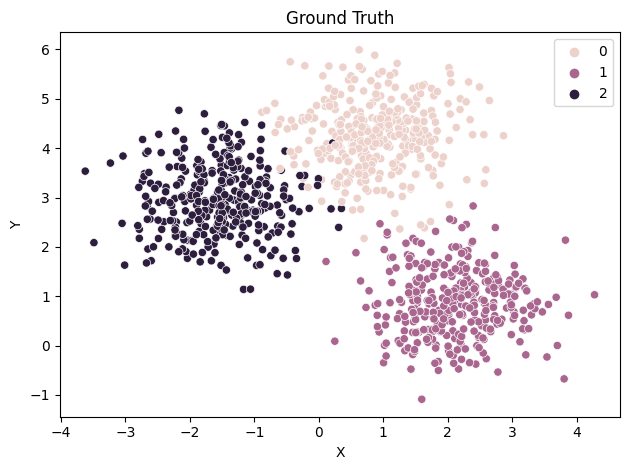

In [6]:
X_blob, y_blob_true = make_blobs(n_samples=1000, centers=3, n_features=2,
                           cluster_std=0.70, random_state=0)

# X_blob is a 2-dimensional array (for the two features we have generated)
# here we split it into the x, y coordinates into separate arrays.
# In a real application, this would be our "data"
#
# y_blob_true are the true labels generated for each data point
x_blob_data=X_blob[0:,0]
y_blob_data=X_blob[0:,1]

sns.scatterplot(x=x_blob_data,y=y_blob_data, hue=y_blob_true)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ground Truth')
plt.tight_layout()
plt.show()

Then we create an instance of our clustering algorithm and look at the resulting labels per datapoint

In [7]:
dbscan = DBSCAN(eps=0.25, min_points=5)
labels = dbscan.fit(X_blob)

In [8]:
# each point is assigned a label by the clustering algorithm
print(labels)

[ 1.  2.  1.  1.  1.  3.  2. -1.  3.  2. -1.  1.  1.  2.  2.  3.  1.  3.
  2.  2.  1.  3.  1.  2.  2.  2.  2.  2.  3.  3.  1.  1.  1.  2.  1.  3.
  3.  1.  3.  3.  3.  3.  2.  3.  3.  3.  3.  1.  2.  3.  2.  2.  3.  2.
  2.  3.  3.  1.  1.  3.  1.  1.  1.  1.  2.  2.  3.  3.  1.  1.  2.  2.
  2.  1.  2.  1.  3.  2.  1. -1.  1.  2.  2.  2. -1.  2.  2.  3.  2.  3.
  2.  3.  3.  1.  3.  1.  2. -1.  2.  1.  2.  2.  2.  3.  2.  2.  1.  2.
  3.  3.  2.  2.  2. -1.  1.  1.  2.  1.  2.  3.  2.  3.  1.  2. -1.  3.
  1.  1.  1.  2.  2.  1.  2.  2.  1. -1.  2.  3.  1.  1. -1.  2.  2.  1.
  1.  1.  2.  2.  1.  2.  2.  1.  2.  2.  2.  1.  2.  3.  3. -1.  2.  2.
  2.  2. -1.  2.  1.  2.  3.  3.  3.  1.  1.  1.  1.  2. -1.  2.  2.  1.
  2.  2.  2. -1.  3.  2.  6.  3.  1.  2. -1.  1. -1.  1. -1.  2. -1. -1.
  3.  3.  2.  1.  3. -1.  2. -1. -1. -1. -1.  2.  1.  5.  2.  2.  3.  1.
 -1.  1.  2. -1.  1.  4.  1.  1.  2.  3.  2.  2.  2.  1.  1.  3.  2.  3.
  2.  3.  2.  3.  1.  1.  1. -1.  1.  1.  2.  1. -1

Finally, we put all datapoints that belong to a cluster into an numpy array (i.e. all labels not equal to -1) and similarly for all noise points (label equal to -1).
Then we plot all clusters and noise points

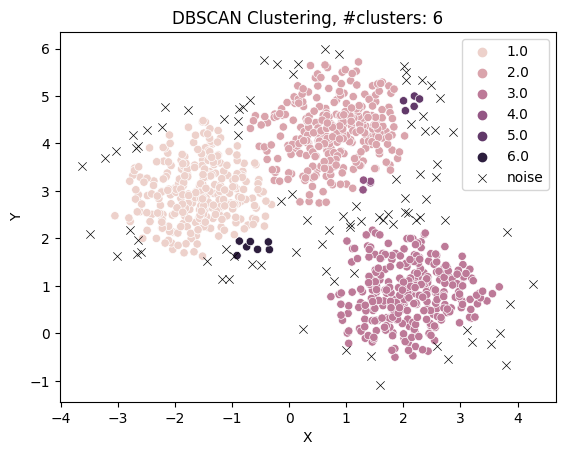

In [9]:
# group the data into the clusters (all labels not equal to -1) and noise
# (labels equal to -1). Noise points are not associated with a cluster.

clusters = np.array([X_blob[i] for i in range(len(labels)) if labels[i] != -1])
noise = np.array([X_blob[i] for i in range(len(labels)) if labels[i] == -1])

# plot the clusters and noise
fig, ax = plt.subplots()
sns.scatterplot(x=clusters[:, 0],y=clusters[:, 1], hue=labels[labels != -1])
sns.scatterplot(x=noise[:, 0],y=noise[:, 1], c='black', marker='x', label='noise')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering, #clusters: '+ str(len(set(labels)) - 1))

# matplotlib only
#ax.scatter(clusters[:, 0], clusters[:, 1], c=labels[labels != -1], label = 'cluster')
#ax.scatter(noise[:, 0], noise[:, 1], c='black', marker='x', label='noise')
plt.legend()
plt.show()